## Taylor Swift Lyrics Analysis Project

This project focuses on the songs from Taylor Swift's 7 studio albums (self-titled, Fearless, Speak Now, Red, 1989, reputation and Lover). On Kaggle, I found a dataset uploaded by PromptCloud who collected the lyrics of the first 6 albums (from self-titled to reputation). For Taylor's newest album Lover, I scraped the lyrics pages of songs in this album on https://www.azlyrics.com/. 

Kaggle dataset link: https://www.kaggle.com/PromptCloudHQ/taylor-swift-song-lyrics-from-all-the-albums

In [1]:
# Data processing and visualization libs
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import pyvis
from pyvis.network import Network

# Web scraping libs
import requests
from bs4 import BeautifulSoup

# NLP libs
import nltk
import nltk.corpus
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

## Part I: Get the Lyrics

In [2]:
# The Kaggle dataset is named taylor_swift_lyrics.csv. Read in the lyrics of first 6 albums
lyrics = pd.read_csv('taylor_swift_lyrics.csv')

# Each row of this dataset is one single line of lyrics of each song, which is not what we want.
lyrics.head()

,artist,album,track_title,track_n,lyric,line,year
0,Taylor Swift,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006
1,Taylor Swift,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006
2,Taylor Swift,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006
3,Taylor Swift,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006
4,Taylor Swift,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006


In [4]:
# Concatenate the lyrics of each songs using groupby
songs_part1 = lyrics[['album', 'track_title', 'lyric']].groupby(['album', 'track_title']).agg({'lyric': lambda x: x.str.cat(sep = ' ')}).reset_index()

# Change the column lyric to lyric_all
songs_part1.columns = ['album', 'track_title', 'lyric_all']
songs_part1.head()

,album,track_title,lyric_all
0,1989,All You Had to Do Was Stay,People like you always want back The love they...
1,1989,Bad Blood,"'Cause baby, now we've got bad blood You know ..."
2,1989,Blank Space,"Nice to meet you, where you been? I could show..."
3,1989,Clean,The drought was the very worst When the flower...
4,1989,How You Get The Girl,"Uh, uh, uh Uh, uh, uh Uh-uh, uh-uh Stand there..."


In [5]:
# Before we continue, we need to get the lyrics of songs in album Lover

# I found a website (https://www.azlyrics.com) that provides the lyrics of songs in Lover
# The root_url is the lyrics page of the first song 'I Forgot That You Existed' in album Lover
# This page also contains all the other lyrics pages' links on https://www.azlyrics.com
# I scraped this page to get all the lyrics pages' links
root_url = 'https://www.azlyrics.com/lyrics/taylorswift/iforgotthatyouexisted.html'
root_html = requests.get(root_url)
root_bs = BeautifulSoup(root_html.text, 'html.parser')

In [6]:
# Store each song's title in lover_track_title
lover_track_title = [track.get_text() for track in root_bs.find_all('div', class_= 'panel songlist-panel noprint')[0].find_all('a')]

In [7]:
# Store each song's lyrics page link in lover_track_url
lover_track_url = ['https://www.azlyrics.com/lyrics/taylorswift/' + track['href'] for track in root_bs.find_all('div', class_= 'panel songlist-panel noprint')[0].find_all('a')]

In [8]:
lover_track_url

['https://www.azlyrics.com/lyrics/taylorswift/iforgotthatyouexisted.html',
 'https://www.azlyrics.com/lyrics/taylorswift/cruelsummer.html',
 'https://www.azlyrics.com/lyrics/taylorswift/lover.html',
 'https://www.azlyrics.com/lyrics/taylorswift/theman.html',
 'https://www.azlyrics.com/lyrics/taylorswift/thearcher.html',
 'https://www.azlyrics.com/lyrics/taylorswift/ithinkheknows.html',
 'https://www.azlyrics.com/lyrics/taylorswift/missamericanatheheartbreakprince.html',
 'https://www.azlyrics.com/lyrics/taylorswift/paperrings.html',
 'https://www.azlyrics.com/lyrics/taylorswift/corneliastreet.html',
 'https://www.azlyrics.com/lyrics/taylorswift/deathbyathousandcuts.html',
 'https://www.azlyrics.com/lyrics/taylorswift/londonboy.html',
 'https://www.azlyrics.com/lyrics/taylorswift/soonyoullgetbetter.html',
 'https://www.azlyrics.com/lyrics/taylorswift/falsegod.html',
 'https://www.azlyrics.com/lyrics/taylorswift/youneedtocalmdown.html',
 'https://www.azlyrics.com/lyrics/taylorswift/after

In [9]:
# Create a new dataframe lover to store the lyrics data of album Lover
lover = pd.DataFrame(index = range(0, len(lover_track_url)), columns = ['album', 'track_title', 'lyric_all'])
lover['album'] = 'Lover'
lover['track_title'] = lover_track_title

# Scrape each song's lyrics page, get the lyrics, tokenize them and store the data
for t in range(0, len(lover_track_title)):
    url = lover_track_url[t]
    html = requests.get(url)
    bs = BeautifulSoup(html.text, 'html.parser')
    lover.loc[t, 'lyric_all'] = bs.find_all('div')[9].find_all('div')[9].get_text()

# There are some \n and \r in the data (at the beginning for example) and we need to remove them
lover.head()

,album,track_title,lyric_all
0,Lover,I Forgot That You Existed,\n\r\nHow many days did I spend thinking\n'Bou...
1,Lover,Cruel Summer,"\n\r\n(Yeah, yeah, yeah, yeah)\n\nFever dream ..."
2,Lover,Lover,\n\r\nWe could leave the Christmas lights up '...
3,Lover,The Man,"\n\r\nI would be complex, I would be cool\nThe..."
4,Lover,The Archer,\n\r\nCombat\nI'm ready for combat\nI say I do...


In [10]:
# Replace the \n and \r with blankspaces to avoid unwanted concatenation
lover['lyric_all'] = lover['lyric_all'].apply(lambda x: x.replace('\n', ' ').replace('\r', ' '))
lover.head()

,album,track_title,lyric_all
0,Lover,I Forgot That You Existed,How many days did I spend thinking 'Bout ho...
1,Lover,Cruel Summer,"(Yeah, yeah, yeah, yeah) Fever dream high ..."
2,Lover,Lover,We could leave the Christmas lights up 'til...
3,Lover,The Man,"I would be complex, I would be cool They'd ..."
4,Lover,The Archer,Combat I'm ready for combat I say I don't w...


In [11]:
# So far, we have successfully collected the lyrics data of album Lover and are ready to join it with the previous dataset songs
# Append lover to songs
songs = songs_part1.append(lover, ignore_index = True)

## Part II: Preprocess the Lyrics

In [16]:
# Replace punctuations with whitespace.
songs['lyric_all'] = songs['lyric_all'].apply(lambda x: x.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))))

In [17]:
# Tokenize the lyrics: break the lyrics into single lowercase words instead of sentences.
songs['lyric_all'] = songs['lyric_all'].apply(lambda x: x.lower().split(sep = ' '))
songs.head()

,album,track_title,lyric_all
0,1989,All You Had to Do Was Stay,"[people, like, you, always, want, back, the, l..."
1,1989,Bad Blood,"[, cause, baby, , now, we, ve, got, bad, blood..."
2,1989,Blank Space,"[nice, to, meet, you, , where, you, been, , i,..."
3,1989,Clean,"[the, drought, was, the, very, worst, when, th..."
4,1989,How You Get The Girl,"[uh, , uh, , uh, uh, , uh, , uh, uh, uh, , uh,..."


In [18]:
# Remove the blankspaces used to replace \n, \r and punctuations
songs['lyric_all'] = songs['lyric_all'].apply(lambda xs: [x for x in xs if x not in [' ', '']])

In [19]:
# Get the total counts of words
songs['total_count'] = songs['lyric_all'].apply(len)

In [20]:
# Remove stopwords.
stop_words = set(stopwords.words('english'))
songs['lyric'] = songs['lyric_all'].apply(lambda xs: [x for x in xs if x not in stop_words])

In [22]:
# Lemmatize each word.
lm = WordNetLemmatizer()
pst = PorterStemmer()
songs['lyric'] = songs['lyric'].apply(lambda xs: [lm.lemmatize(pst.stem(x)) for x in xs])
songs['lyric_all'] = songs['lyric_all'].apply(lambda xs: [lm.lemmatize(pst.stem(x)) for x in xs])

In [25]:
songs.sort_values(by = 'total_count', ascending = False).head()

,album,track_title,lyric_all,total_count,lyric
85,reputation,End Game (Ft. Ed Sheeran & Future),"[futur, i, wanna, be, your, end, game, i, wann...",762,"[futur, wanna, end, game, wanna, first, string..."
8,1989,Out of the Woods,"[look, at, it, now, it, all, seem, so, simpl, ...",655,"[look, seem, simpl, lie, couch, rememb, took, ..."
9,1989,Shake It Off,"[i, stay, out, too, late, got, noth, in, my, b...",630,"[stay, late, got, noth, brain, peopl, say, mmm..."
86,reputation,Getaway Car,"[no, noth, good, start, in, a, getaway, car, i...",590,"[noth, good, start, getaway, car, best, time, ..."
6,1989,I Wish You Would,"[it, s, 2, 00, am, in, your, car, window, down...",587,"[2, 00, car, window, pas, street, memori, star..."


## Part III: Exploratory Data Analysis

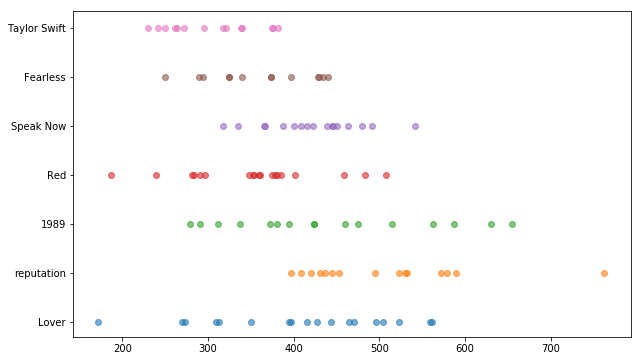

In [21]:
# This scatterplot presents the lyrics counts of songs by album
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
album_title = ['Lover', 'reputation', '1989', 'Red', 'Speak Now', 'Fearless', 'Taylor Swift']
for i in album_title:
    ax.scatter(x = songs.loc[songs.album == i, 'total_count'], y = songs.loc[songs.album == i,'album'], alpha = 0.6)

In [22]:
# We want to know how many unique non-stopword each song uses
songs['unique_count'] = songs['lyric'].apply(lambda x: len(np.unique(x)))

# Divide the unique_count by total_count to better understand how repetitive each song's lyrics is
songs['sparsity'] = songs['unique_count']/songs['total_count']

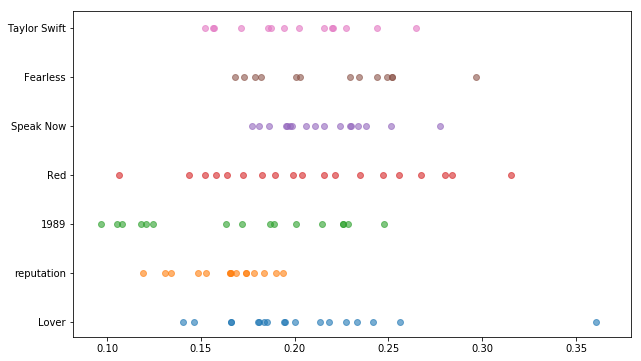

In [23]:
# This scatterplot presents the lyrics sparsity of songs by album
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
album_title = ['Lover', 'reputation', '1989', 'Red', 'Speak Now', 'Fearless', 'Taylor Swift']
for i in album_title:
    ax.scatter(x = songs.loc[songs.album == i, 'sparsity'], y = songs.loc[songs.album == i,'album'], alpha = 0.6)

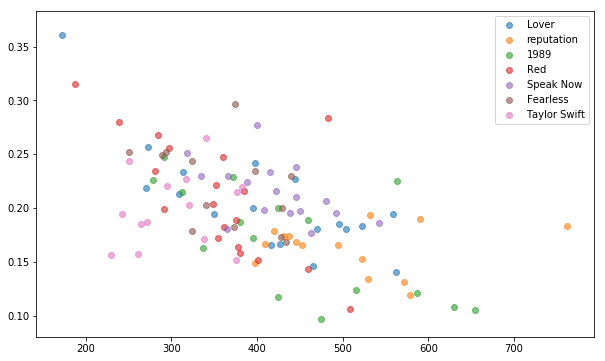

In [24]:
# Plot total_count against sparsity
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
for i in album_title:
    ax.scatter(x = songs.loc[songs.album == i, 'total_count'], y = songs.loc[songs.album == i, 'sparsity'], alpha = 0.6)
ax.legend(album_title)

In [25]:
# Write a csv file to store the data for visualization in Tableau
songs[['album', 'track_title', 'total_count', 'unique_count', 'sparsity']].to_csv('ts_lyrics.csv')

In [26]:
# Aggregate the lyrics into album level and still calculate the unique count and sparsity of each album as we did just now for each song
albums = songs[['album','total_count', 'lyric', 'lyric_all']].groupby('album').agg({'lyric':lambda x: sum(x, []), 'lyric_all':lambda x: sum(x, []), 'total_count':sum})
albums['unique_count'] = albums['lyric'].apply(lambda x: len(np.unique(x)))
albums['sparsity'] = albums['unique_count']/albums['total_count']

In [27]:
# Calculate the frequency of each unqiue word in each album
albums['freq'] = albums['lyric'].apply(collections.Counter)
# albums['freq_all'] = albums['lyric_all'].apply(collections.Counter)
albums

,lyric,lyric_all,total_count,unique_count,sparsity,freq
album,,,,,,
1989,"[peopl, like, alway, want, back, love, gave, a...","[peopl, like, you, alway, want, back, the, lov...",7099,619,0.087195,"{'peopl': 11, 'like': 42, 'alway': 6, 'want': ..."
Fearless,"[see, face, mind, drive, away, cau, none, us, ...","[i, see, your, face, in, my, mind, as, i, driv...",4696,516,0.109881,"{'see': 21, 'face': 2, 'mind': 4, 'drive': 6, ..."
Lover,"[mani, day, spend, think, bout, wrong, wrong, ...","[how, mani, day, did, i, spend, think, bout, h...",7345,783,0.106603,"{'mani': 2, 'day': 5, 'spend': 1, 'think': 23,..."
Red,"[feel, like, perfect, night, dress, like, hips...","[it, feel, like, a, perfect, night, to, dress,...",6723,677,0.100699,"{'feel': 24, 'like': 92, 'perfect': 3, 'night'..."
Speak Now,"[glad, made, time, see, life, tell, famili, se...","[i, m, so, glad, you, made, time, to, see, me,...",7174,730,0.101756,"{'glad': 2, 'made': 10, 'time': 30, 'see': 34,..."
Taylor Swift,"[would, wanna, break, perfectli, good, heart, ...","[whi, would, you, wanna, break, a, perfectli, ...",4263,439,0.102979,"{'would': 21, 'wanna': 21, 'break': 9, 'perfec..."
reputation,"[knew, killer, first, time, saw, wonder, mani,...","[knew, he, wa, a, killer, first, time, that, i...",7575,714,0.094257,"{'knew': 7, 'killer': 1, 'first': 30, 'time': ..."


In [28]:
# Define a function to find top n elements in a dict according to value
def dict_top(dic, top):
    d_k = sorted(dic, key = dic.get, reverse = True)[:top]
    d_v = [dic.get(k) for k in d_k]
    return {k:v for (k, v) in zip(d_k, d_v)}

In [29]:
# Get the top 20 most frequent words in each album
albums['freq_top20'] = albums['freq'].apply(lambda x: dict_top(x, 20))
albums

,lyric,lyric_all,total_count,unique_count,sparsity,freq,freq_top20
album,,,,,,,
1989,"[peopl, like, alway, want, back, love, gave, a...","[peopl, like, you, alway, want, back, the, lov...",7099,619,0.087195,"{'peopl': 11, 'like': 42, 'alway': 6, 'want': ...","{'shake': 79, 'ey': 72, 'yet': 64, 'love': 62,..."
Fearless,"[see, face, mind, drive, away, cau, none, us, ...","[i, see, your, face, in, my, mind, as, i, driv...",4696,516,0.109881,"{'see': 21, 'face': 2, 'mind': 4, 'drive': 6, ...","{'know': 58, 'feel': 34, 'oh': 27, 'la': 26, '..."
Lover,"[mani, day, spend, think, bout, wrong, wrong, ...","[how, mani, day, did, i, spend, think, bout, h...",7345,783,0.106603,"{'mani': 2, 'day': 5, 'spend': 1, 'think': 23,...","{'oh': 97, 'like': 74, 'ooh': 70, 'want': 52, ..."
Red,"[feel, like, perfect, night, dress, like, hips...","[it, feel, like, a, perfect, night, to, dress,...",6723,677,0.100699,"{'feel': 24, 'like': 92, 'perfect': 3, 'night'...","{'know': 101, 'like': 92, 'oh': 72, 'time': 68..."
Speak Now,"[glad, made, time, see, life, tell, famili, se...","[i, m, so, glad, you, made, time, to, see, me,...",7174,730,0.101756,"{'glad': 2, 'made': 10, 'time': 30, 'see': 34,...","{'back': 64, 'like': 60, 'know': 44, 'go': 37,..."
Taylor Swift,"[would, wanna, break, perfectli, good, heart, ...","[whi, would, you, wanna, break, a, perfectli, ...",4263,439,0.102979,"{'would': 21, 'wanna': 21, 'break': 9, 'perfec...","{'know': 40, 'oh': 33, 'think': 31, 'back': 25..."
reputation,"[knew, killer, first, time, saw, wonder, mani,...","[knew, he, wa, a, killer, first, time, that, i...",7575,714,0.094257,"{'knew': 7, 'killer': 1, 'first': 30, 'time': ...","{'oh': 59, 'made': 53, 'like': 52, 'want': 51,..."


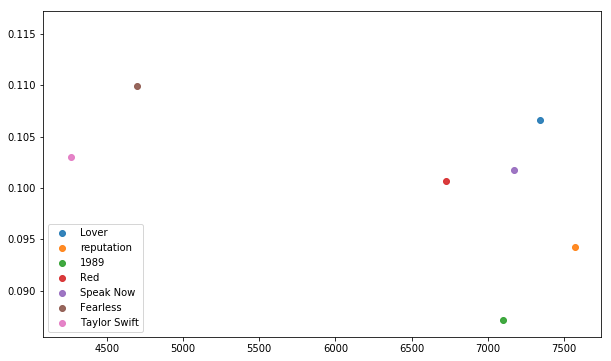

In [30]:
# Simple visualization of the sparsity and total words count of each album
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
for i in album_title:
    ax.scatter(x = albums.loc[i, 'total_count'], y = albums.loc[i, 'sparsity'], alpha = 0.9)
ax.legend(album_title)

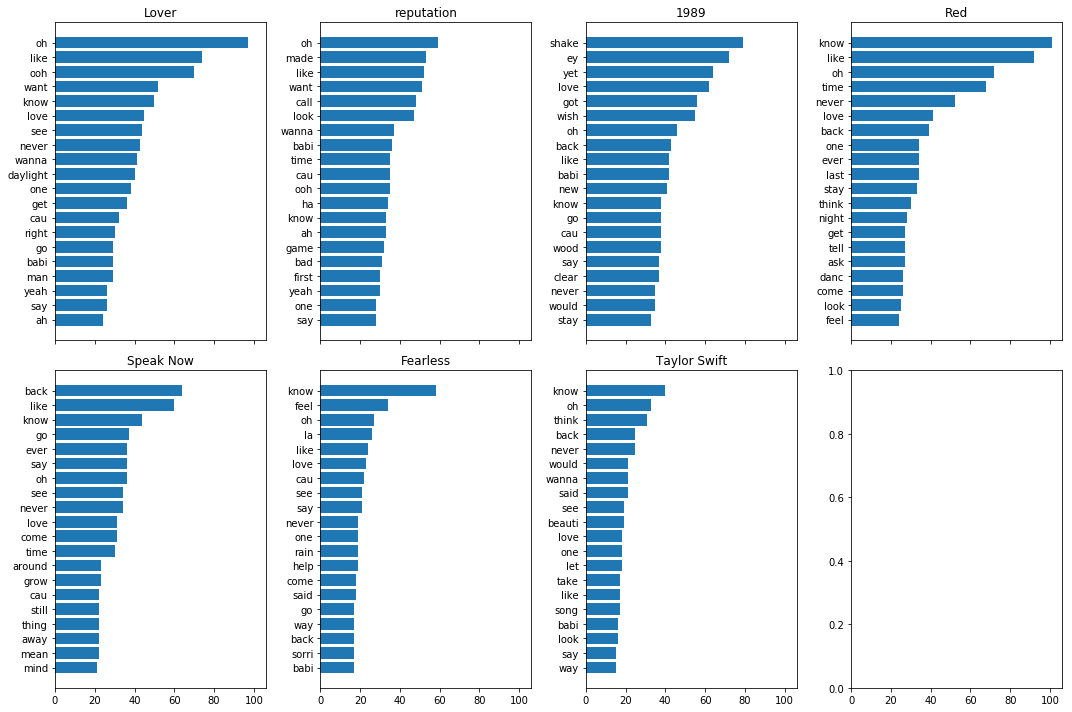

In [31]:
# Present the frequency of the top 20 most frequent words of each album
fig, ax = plt.subplots(2, 4, sharex='all', figsize = (15, 10)) 
for i in range(len(album_title)):
    x = int(i/4)
    y = int(i%4)
    ax[x, y].barh(np.arange(20), list(albums.loc[album_title[i], 'freq_top20'].values()))
    ax[x, y].set_yticks(np.arange(20))
    ax[x, y].set_yticklabels(list(albums.loc[album_title[i], 'freq_top20'].keys()))
    ax[x, y].set_title(album_title[i])
    ax[x, y].invert_yaxis()
fig.tight_layout()

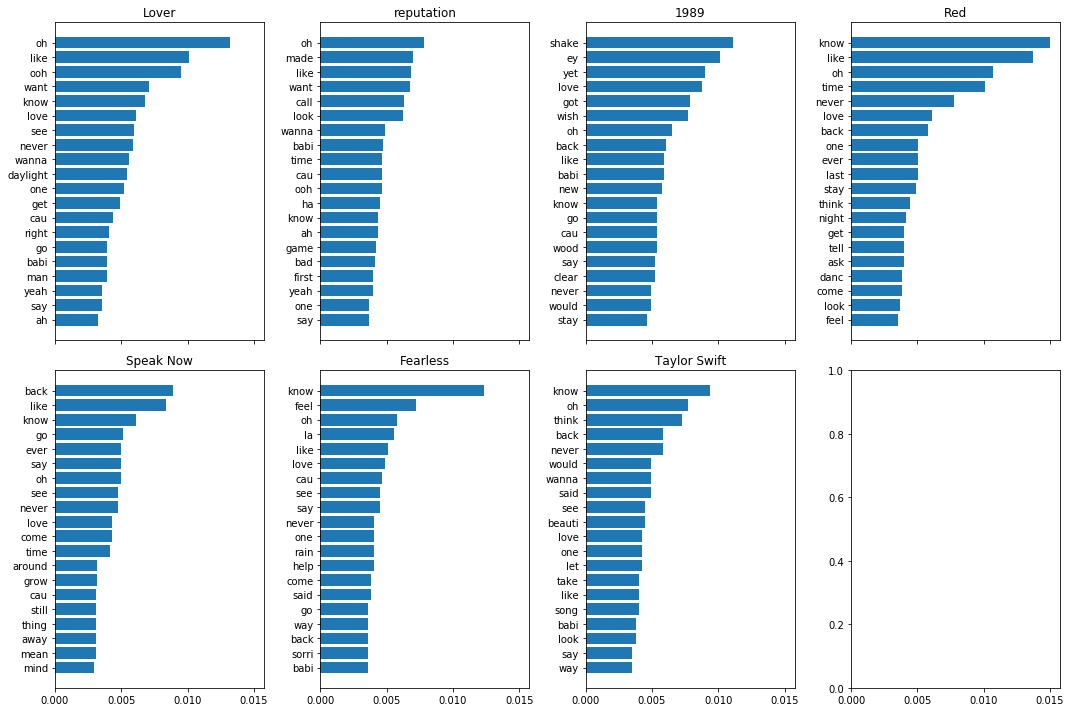

In [32]:
# Present the frequency/total words count of the top 20 most frequent words of each album
fig, ax = plt.subplots(2, 4, sharex='all', figsize = (15, 10)) 
for i in range(len(album_title)):
    x = int(i/4)
    y = int(i%4)
    ax[x, y].barh(np.arange(20), [v/albums.loc[album_title[i], 'total_count'] for v in list(albums.loc[album_title[i], 'freq_top20'].values())])
    ax[x, y].set_yticks(np.arange(20))
    ax[x, y].set_yticklabels(list(albums.loc[album_title[i], 'freq_top20'].keys()))
    ax[x, y].set_title(album_title[i])
    ax[x, y].invert_yaxis()
fig.tight_layout()

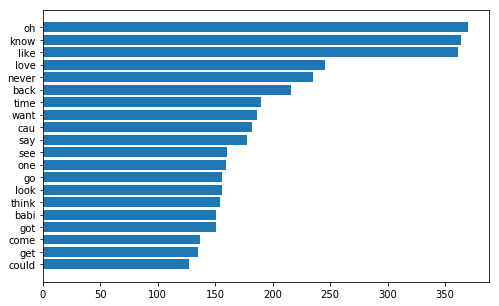

In [33]:
# Present the frequency top 20 most frequent words of all albums
all_albums_top20 = dict_top(collections.Counter(sum(albums['lyric'], [])), 20)
plt.figure(figsize = (8, 5))
plt.barh(np.arange(20), list(all_albums_top20.values()))
plt.yticks(np.arange(20), list(all_albums_top20.keys()))
plt.gca().invert_yaxis()
plt.show()

## Part IV: TF-IDF Analysis

In [34]:
def tf_idf(dic):
    # Get all the words in dic
    ind = []
    for i in dic.index:
        ind += dic[i].keys()
    ind = set(ind)
    
    # Create a dataframe to store all the words info
    tf_idf_df = pd.DataFrame(columns = dic.index, index = ind)
    
    # Import all the words info
    for i in dic.index:
        tf_idf_df[i] = pd.Series(dic[i])
    
    # Fill all the NAs with 0
    tf_idf_df = tf_idf_df.fillna(0)
    
    # Calculate the idf of each word
    tf_idf_df['idf'] = np.log((len(dic.index) + 1)/((tf_idf_df > 0).sum(axis = 1) + 1)) + 1
    
    # Calculate the tf of each word
    tf_idf_df[dic.index] = tf_idf_df[dic.index]/(tf_idf_df[dic.index].sum())
    
    # Multiply tf with idf
    tf_idf_df[dic.index] = tf_idf_df[dic.index].apply(lambda x: x * tf_idf_df['idf'], axis = 0)
    
    # Reset the index and drop the idf column
    tf_idf_df = tf_idf_df.reset_index().rename(columns = {'index':'word'}).drop(columns = 'idf', axis = 0)
    
    # Return the final dataframe
    return tf_idf_df

In [35]:
album_tf_idf = tf_idf(albums['freq'])
album_tf_idf.head()

album,word,1989,Fearless,Lover,Red,Speak Now,Taylor Swift,reputation
0,doin,0.000000,0.0,0.000000,0.0,0.0,0.0,0.007602
1,type,0.000000,0.0,0.000609,0.0,0.0,0.0,0.001262
2,cloud,0.000743,0.0,0.000000,0.0,0.0,0.0,0.000000
3,aglow,0.000743,0.0,0.000000,0.0,0.0,0.0,0.000000
4,beer,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000760


In [36]:
album_tf_idf = album_tf_idf[album_tf_idf.word.map(len) > 2]

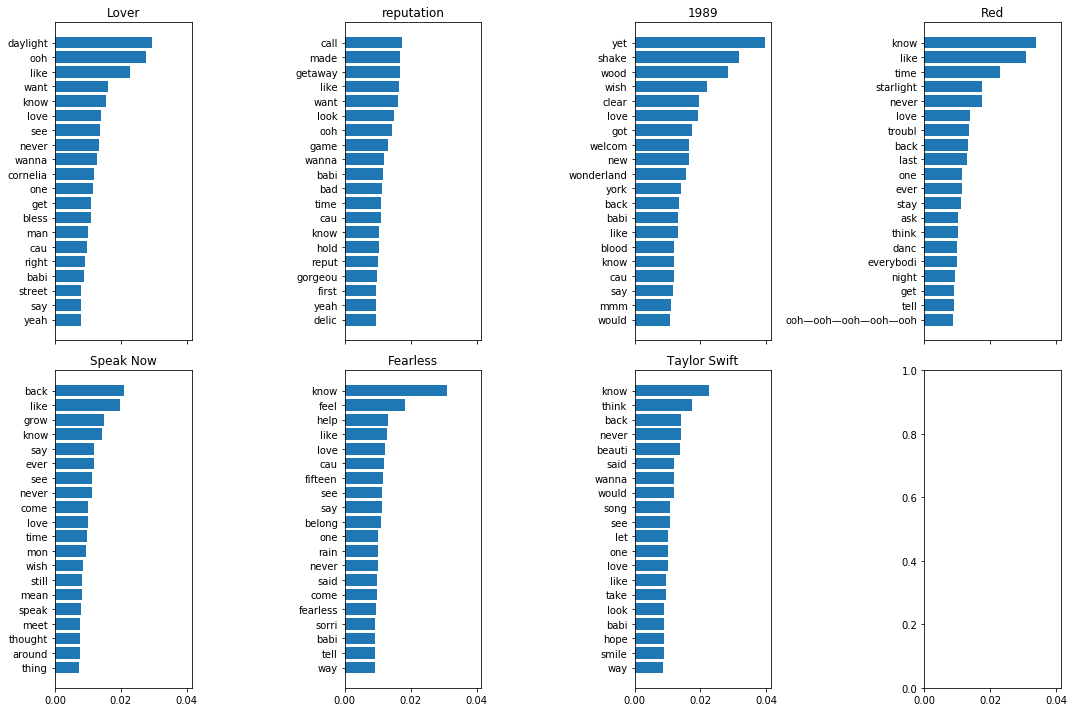

In [37]:
fig, ax = plt.subplots(2, 4, sharex = 'all', figsize = (15, 10))
for i in range(len(album_title)):
    x = int(i/4)
    y = int(i%4)
    sorted_df = album_tf_idf[['word', album_title[i]]].sort_values(by = album_title[i], ascending = False)[:20]
    tf_idf = list(sorted_df[album_title[i]])
    words = list(sorted_df['word'])
    ax[x, y].barh(range(20), tf_idf)
    ax[x, y].set_yticks(np.arange(20))
    ax[x, y].set_yticklabels(words)
    ax[x, y].set_title(album_title[i])
    ax[x, y].invert_yaxis()
fig.tight_layout()

## Part V: Comparative Analysis

In [38]:
import gensim
from gensim.models import LdaModel
from gensim import corpora
from scipy.stats import entropy

import os
from gensim.models import Word2Vec
import pyemd

### Part 5.1: LDA with Jensen-Shannon Distance

In [39]:
song_dict = corpora.Dictionary(songs.lyric)
song_corp = [song_dict.doc2bow(d) for d in songs.lyric]
song_lda = LdaModel(corpus = song_corp, num_topics = 7, id2word = song_dict, passes = 5, alpha=1e-2, eta=0.5e-2, minimum_probability=0.0)

In [40]:
song_topic_dist = np.array([[t[1] for t in l] for l in song_lda[song_corp]])

In [41]:
def JS(doc_mat):
    js_df = pd.DataFrame()
    for i in range(len(doc_mat)):
        doc = doc_mat[i][None, :].T
        js_df[songs.index[i]] = np.sqrt(0.5*(entropy(doc, 0.5*(doc + doc_mat.T)) + entropy(doc_mat.T, 0.5*(doc + doc_mat.T))))
    js_df.columns = songs.track_title
    js_df.index = songs.track_title
    return js_df

In [42]:
song_js = JS(song_topic_dist)

C:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


In [320]:
song_js_edge_top = top_edge(song_js, 3, 0.1)

In [321]:
vis_net = Network(height="600px", width="100%", bgcolor="#ffffff", font_color="black", notebook = True)

In [322]:
album_color = songs.album.replace({'Taylor Swift':'#68f558', 'Fearless':'#e8f558', 'Speak Now':'#a958f5', 'Red':'#f55858', '1989':'#f5ae58', 'reputation':'#000000', 'Lover':'#ffa1a1'})
vis_net.add_nodes(songs.track_title.replace('22', '22 (Twenty Two)').values, color = album_color, size = np.ones(len(songs.track_title))*20)

In [323]:
vis_net.add_edges(song_js_edge_top)

In [324]:
vis_net.toggle_physics(True)
vis_net.show('example.html')

### Part 5.2: Word Mover's Distance

In [49]:
%cd C:\Users\young\Documents\GitHub\TS_Lyrics_Project

C:\Users\young\Documents\GitHub\TS_Lyrics_Project


In [50]:
if not os.path.exists('GoogleNews-vectors-negative300.bin.gz'):
    raise ValueError("SKIP: You need to download the google news model")

w2v_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
w2v_model.init_sims(replace=True)

In [103]:
def song_wmd(song_doc, wmd_model):
    track_title = song_doc.track_title
    song_wmd_df = pd.DataFrame(columns = track_title, index = track_title)
    for t1 in range(len(track_title)):
        for t2 in range(t1 + 1, len(track_title)):
            song_wmd_df.loc[track_title[t1], track_title[t2]] = wmd_model.wmdistance(songs.lyric[t1], songs.lyric[t2])
    song_wmd_df.fillna(0, inplace = True)
    song_wmd_df += song_wmd_df.T
    return song_wmd_df

In [74]:
song_wmd_mat = song_wmd(songs.lyric, w2v_model)

In [277]:
def top_edge(song_mat, top, threshold):
    edge_list = []
    track_title = song_mat.columns
    for t in track_title:
        wmd_top = song_mat[t].sort_values(ascending = True)[:top]
        if sum(wmd_top < threshold) == 0:
            continue
        else:
            wmd_top = wmd_top[wmd_top <= threshold]
            source = [t.replace('22', '22 (Twenty Two)')]*len(wmd_top)
            target = [s.replace('22', '22 (Twenty Two)') for s in wmd_top.index]
            value = list(1/(wmd_top.values + 1))
            edge_list += [(s, t, str(v)) for s, t, v in zip(source, target, value) if s != t]
    return edge_list

In [360]:
song_wmd_edge_top = top_edge(song_wmd_mat, 1, 0.9)

In [361]:
vis_net = Network(height="600px", width="100%", bgcolor="#ffffff", font_color="black", notebook = True)

In [362]:
album_color = songs.album.replace({'Taylor Swift':'#68f558', 'Fearless':'#e8f558', 'Speak Now':'#a958f5', 'Red':'#f55858', '1989':'#f5ae58', 'reputation':'#000000', 'Lover':'#ffa1a1'})
vis_net.add_nodes(songs.track_title.replace('22', '22 (Twenty Two)').values, color = album_color, size = np.ones(len(songs.track_title))*20)

In [363]:
vis_net.add_edges(song_wmd_edge_top)

In [364]:
vis_net.toggle_physics(True)
vis_net.show('example.html')